In [ ]:
!pip install transformers datasets torch
!pip install kaggle

import os
os.environ["WANDB_DISABLED"] = "true"  # Disable wandb logging
from google.colab import files


In [ ]:
# Upload your SQuAD-v1.1 CSV file
uploaded = files.upload()

import pandas as pd

# Load CSV
df = pd.read_csv('SQuAD-v1.1.csv')
print("Columns in CSV:", df.columns.tolist())


Saving SQuAD-v1.1.csv to SQuAD-v1.1.csv
Columns in CSV: ['title', 'context', 'question', 'answer', 'answer_start', 'answer_end']


In [ ]:
from datasets import Dataset

# Create 'answers' column for QA models
df['answers'] = df.apply(lambda x: {"text": [x['answer']], "answer_start": [x['answer_start']]}, axis=1)

# Create dataset
dataset = Dataset.from_pandas(df[['context', 'question', 'answers']])

# Split for training
train_dataset = dataset
print("Initial columns:", train_dataset.column_names)


Initial columns: ['context', 'question', 'answers']


In [ ]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_qa(examples):
    return tokenizer(
        examples['question'],
        examples['context'],
        truncation=True,
        padding="max_length",
        max_length=384
    )

train_dataset = train_dataset.map(tokenize_qa, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        padding="max_length",
        return_offsets_mapping=True,
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        if not answers[i] or not answers[i]['text'] or answers[i]['text'][0] is None:
            start_positions.append(tokenizer.cls_token_id)
            end_positions.append(tokenizer.cls_token_id)
            continue

        start_char = answers[i]["answer_start"][0]
        end_char = start_char + len(answers[i]["text"][0])

        sequence_ids = inputs.sequence_ids(i)
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(tokenizer.cls_token_id)
            end_positions.append(tokenizer.cls_token_id)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

train_dataset_processed = train_dataset.map(preprocess_function, batched=True)
print("Processed dataset columns:", train_dataset_processed.column_names)


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Processed dataset columns: ['context', 'question', 'answers', 'input_ids', 'attention_mask', 'start_positions', 'end_positions']


In [ ]:
split_dataset = train_dataset_processed.train_test_split(test_size=0.1)
train_dataset_final = split_dataset['train']
val_dataset_final = split_dataset['test']


In [ ]:
from transformers import AutoModelForQuestionAnswering, Trainer, TrainingArguments

baseline_model = AutoModelForQuestionAnswering.from_pretrained(model_name)

baseline_args = TrainingArguments(
    output_dir="./baseline_results",
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # Full training
    weight_decay=0.01,
    logging_dir='./logs_baseline',
    logging_steps=100,
    load_best_model_at_end=False  # No early stopping for baseline
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    train_dataset=train_dataset_final,
    eval_dataset=val_dataset_final,
    tokenizer=tokenizer
)

baseline_trainer.train()
baseline_trainer.save_model("baseline_model")
tokenizer.save_pretrained("baseline_model")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2078976954.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


Step,Training Loss,Validation Loss
500,1.961100,1.719727
1000,1.734200,1.490546
1500,1.583200,1.405777
2000,1.660600,1.362891
2500,1.536100,1.306891
3000,1.382500,1.289250
3500,1.389000,1.304029
4000,1.370100,1.258287
4500,1.285000,1.233070
5000,1.258300,1.226752


('baseline_model/tokenizer_config.json',
 'baseline_model/special_tokens_map.json',
 'baseline_model/vocab.txt',
 'baseline_model/added_tokens.json',
 'baseline_model/tokenizer.json')

In [ ]:
modified_model = AutoModelForQuestionAnswering.from_pretrained(model_name)

modified_args = TrainingArguments(
    output_dir="./modified_results",
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs_modified',
    logging_steps=100,
    load_best_model_at_end=True  # Early stopping
)

from transformers import EarlyStoppingCallback

modified_trainer = Trainer(
    model=modified_model,
    args=modified_args,
    train_dataset=train_dataset_final,
    eval_dataset=val_dataset_final,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

modified_trainer.train()
modified_trainer.save_model("modified_model")
tokenizer.save_pretrained("modified_model")


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2548255554.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  modified_trainer = Trainer(


Step,Training Loss,Validation Loss
500,2.206200,1.924787
1000,1.808000,1.537378
1500,1.640000,1.422353
2000,1.694200,1.387084
2500,1.553200,1.333147
3000,1.421300,1.283776
3500,1.385000,1.296914
4000,1.422500,1.270754
4500,1.315800,1.252626
5000,1.281000,1.236682


('modified_model/tokenizer_config.json',
 'modified_model/special_tokens_map.json',
 'modified_model/vocab.txt',
 'modified_model/added_tokens.json',
 'modified_model/tokenizer.json')

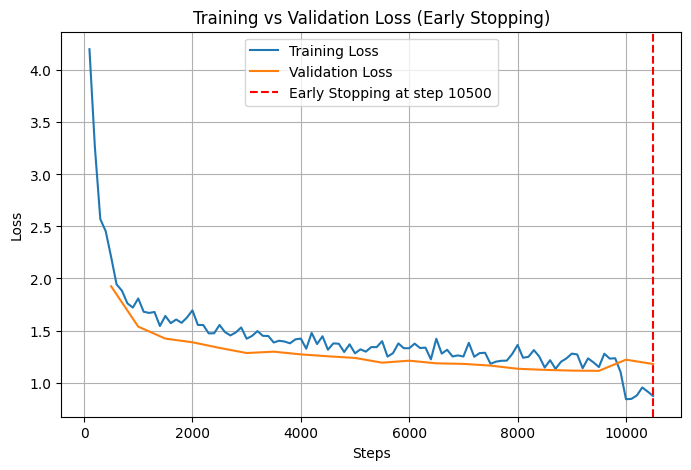

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

log_history = modified_trainer.state.log_history
df_log = pd.DataFrame(log_history)

train_loss = df_log[df_log["loss"].notnull()][["step", "loss"]]
eval_loss = df_log[df_log["eval_loss"].notnull()][["step", "eval_loss"]]

early_stop_step = eval_loss["step"].iloc[-1]

plt.figure(figsize=(8,5))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.axvline(x=early_stop_step, color="red", linestyle="--", label=f"Early Stopping at step {early_stop_step}")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Early Stopping)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from transformers import pipeline
from datasets import load_dataset
import numpy as np

def evaluate_qa_model(model_dir, dataset_split="validation[:500]"):
    qa_pipeline = pipeline(
        "question-answering",
        model=model_dir,
        tokenizer=model_dir,
        device=0
    )

    dataset = load_dataset("squad", split=dataset_split)

    f1_scores = []
    exact_matches = []
    start_acc = []
    end_acc = []

    for example in dataset:
        context = example['context']
        question = example['question']
        true_answer = example['answers']['text'][0] if example['answers']['text'] else ""
        true_start = example['answers']['answer_start'][0] if example['answers']['answer_start'] else None
        true_end = true_start + len(true_answer) if true_start is not None else None

        pred = qa_pipeline(question=question, context=context)
        pred_text = pred['answer']
        pred_start = pred['start']
        pred_end = pred['end']

        # F1
        pred_tokens = pred_text.split()
        ans_tokens = true_answer.split()
        common = set(pred_tokens) & set(ans_tokens)
        f1 = 2 * len(common) / (len(pred_tokens) + len(ans_tokens)) if common else 0
        f1_scores.append(f1)

        # EM
        exact_matches.append(int(pred_text.strip() == true_answer.strip()))

        # Start/End token accuracy
        start_acc.append(int(pred_start == true_start))
        end_acc.append(int(pred_end == true_end))

    return {
        "F1": np.mean(f1_scores),
        "EM": np.mean(exact_matches),
        "First Token Accuracy": np.mean(start_acc),
        "Last Token Accuracy": np.mean(end_acc)
    }

# Evaluate baseline
baseline_metrics = evaluate_qa_model("baseline_model")
print("Baseline Metrics:", baseline_metrics)

# Evaluate modified (early stopping)
modified_metrics = evaluate_qa_model("modified_model")
print("Modified Metrics (Early Stopping):", modified_metrics)


Device set to use cuda:0


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Device set to use cuda:0


Baseline Metrics: {'F1': np.float64(0.7754891690009337), 'EM': np.float64(0.706), 'First Token Accuracy': np.float64(0.742), 'Last Token Accuracy': np.float64(0.71)}
Modified Metrics (Early Stopping): {'F1': np.float64(0.7520687586922881), 'EM': np.float64(0.678), 'First Token Accuracy': np.float64(0.718), 'Last Token Accuracy': np.float64(0.698)}
